## ConceptNet Numberbatch embeddings

**ConceptNet Numberbatch** is built using an ensemble that combines data from **ConceptNet, word2vec, GloVe, and OpenSubtitles 2016**. It is described in the paper *ConceptNet 5.5: An Open Multilingual Graph of General Knowledge, presented at AAAI 2017* (https://arxiv.org/abs/1612.03975).

In [1]:
# Importing libraries
import gensim
from sklearn.manifold import TSNE
from sklearn.manifold import MDS
from sklearn.decomposition import PCA
import numpy as np
import os
from statistics import mean
import pandas as pd 
from nltk.stem import WordNetLemmatizer 
from nltk.stem import PorterStemmer 
from IPython.display import display
pd.options.display.max_columns = None
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

### Constants

In [3]:
TOP_N = 30
KEYS = { \
    "offensive": set(), 
    "abusive": set(), 
    "cyberbullying": set(), 
    "vulgar": set(), 
    "racist": set(), 
    "homophobic": set(), 
    "profane": set(), 
    "slur": set(), 
    "harassment": set(), 
    "obscene": set(), 
    "threat": set(), 
    "discredit": set(), 
    "hateful": set(), 
    "insult": set(), 
    "hostile": set(),
    # additional term: 'sexist'
    "sexist": set()
}
FIXED_KEYS = list(KEYS.keys())

Too similar words that will not be taken into account as neighbouring words:

In [4]:
lemmatizer = WordNetLemmatizer() 
ps = PorterStemmer() 


for key in KEYS.keys():
    lemma = lemmatizer.lemmatize(key)
    stem = ps.stem(key)
    KEYS[key].add(lemma)
    KEYS[key].add(stem)
    KEYS[key].add(key)
KEYS

{'offensive': {'offens', 'offensive'},
 'abusive': {'abus', 'abusive'},
 'cyberbullying': {'cyberbulli', 'cyberbullying'},
 'vulgar': {'vulgar'},
 'racist': {'racist'},
 'homophobic': {'homophob', 'homophobic'},
 'profane': {'profan', 'profane'},
 'slur': {'slur'},
 'harassment': {'harass', 'harassment'},
 'obscene': {'obscen', 'obscene'},
 'threat': {'threat'},
 'discredit': {'discredit'},
 'hateful': {'hate', 'hateful'},
 'insult': {'insult'},
 'hostile': {'hostil', 'hostile'},
 'sexist': {'sexist'}}

### Functions

In [5]:
def same_word(similar_word, ommit_words):
    similar_word = similar_word.replace("_", " ").replace("-", " ").lower()
    
    if similar_word in ommit_words:
        print(f"{ommit_words} -- {similar_word}")
        return True
    
    for ommit_word in ommit_words:
        if ommit_word in similar_word:
            print(f"{ommit_words} -- {similar_word}")
            return True
        
    return False

In [6]:
# We try to find the most similar words to our terms by two measures: cosine similarity and cosine multiplication
def get_similar_words(model_gn, similarity_measure):
    embedding_clusters = []
    word_clusters = []
    for key in FIXED_KEYS:
        ommit_words = KEYS[key]
        embeddings = []
        words = []
        
        # We check which measure we want to use
        if similarity_measure == 'cosine_similarity':
            most_similar_words = model_gn.most_similar(key, topn=TOP_N * 3)
        elif similarity_measure == 'cosine_multiplication':
            most_similar_words = model_gn.most_similar_cosmul(key, topn=TOP_N * 3)
        for similar_word, _ in most_similar_words:
            if not same_word(similar_word, ommit_words):
                words.append(similar_word)
                embeddings.append(model_gn[similar_word])          
                
        if len(words) < TOP_N or len(embeddings) < TOP_N:
            print("ERROR")
            
        words = words[:TOP_N]
        embeddings = embeddings[:TOP_N]
        
        embedding_clusters.append(embeddings)
        word_clusters.append(words)
        
    return (word_clusters, embedding_clusters)

In [7]:
def displayDF(word_clusters):
    df = pd.DataFrame(dict(zip(FIXED_KEYS, word_clusters)))  
    display(df)

In [8]:
def plot_similar_words(title, labels, embedding_clusters, word_clusters, filename=None):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, color=color, alpha=0.7, label=label)
        for i, word in enumerate(words):              
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=8)
        plt.annotate(label.upper(), alpha=1.0, xy=(mean(x), mean(y)), xytext=(0, 0),
            textcoords='offset points', ha='center', va='center', size=15)
    plt.legend(loc=4)
    plt.title(title)
    plt.grid(False)
    if filename:
        plt.savefig(filename, format='png', dpi=150, bbox_inches='tight')
    plt.show()

In [9]:
def plotTSNE(title, word_clusters, embedding_clusters, filename = None):
    embedding_clusters = np.array(embedding_clusters)
    n, m, k = embedding_clusters.shape
    model_en_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32)
    model_en_2d = model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))
    embeddings_en_2d = np.array(model_en_2d).reshape(n, m, 2)
    plot_similar_words(title, FIXED_KEYS, embeddings_en_2d, word_clusters, filename)

In [10]:
def plotMDS(title, word_clusters, embedding_clusters, filename = None):
    embedding_clusters = np.array(embedding_clusters)
    n, m, k = embedding_clusters.shape
    model_en_2d = MDS(n_components=2, max_iter=3500, random_state=32)
    model_en_2d = model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))
    embeddings_en_2d = np.array(model_en_2d).reshape(n, m, 2)
    plot_similar_words(title, FIXED_KEYS, embeddings_en_2d, word_clusters, filename)

In [11]:
def plotPCA(title, word_clusters, embedding_clusters, filename = None):
    embedding_clusters = np.array(embedding_clusters)
    n, m, k = embedding_clusters.shape
    model_en_2d = PCA(n_components=2, random_state = 32)
    model_en_2d = model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))
    embeddings_en_2d = np.array(model_en_2d).reshape(n, m, 2)
    plot_similar_words(title, FIXED_KEYS, embeddings_en_2d, word_clusters, filename)

## Loading the embeddings

The ConceptNet Numberbatch embeddings can be downloaded from the following webpage: https://www.kaggle.com/joeskimo/conceptnet. The embeddings were not pushed to the repository, because of their size.

In [2]:
# These embeddings are available in the folder ConceptNet_Numberbatch_embeddings on our GDrive. Inside the folder, you will find
# this file 'numberbatch-en-19.08.txt'.
model = gensim.models.keyedvectors.KeyedVectors.load_word2vec_format('numberbatch-en-19.08.txt')  

Getting similar words. Printed out words are neighboring words that are ommited for the analysis.

In [12]:
word_clusters, embedding_clusters = get_similar_words(model, similarity_measure='cosine_similarity')

{'offensive', 'offens'} -- on offensive
{'offensive', 'offens'} -- nonoffensive
{'offensive', 'offens'} -- offensively
{'offensive', 'offens'} -- unoffensive
{'abus', 'abusive'} -- unabusive
{'abus', 'abusive'} -- nonabusive
{'abus', 'abusive'} -- abusiveness
{'abus', 'abusive'} -- abusefulness
{'abus', 'abusive'} -- abuseful
{'abus', 'abusive'} -- abusefully
{'abus', 'abusive'} -- nonabuser
{'abus', 'abusive'} -- abusing
{'abus', 'abusive'} -- abuse
{'abus', 'abusive'} -- antiabuse
{'abus', 'abusive'} -- abusage
{'abus', 'abusive'} -- re abuse
{'abus', 'abusive'} -- abusement
{'abus', 'abusive'} -- abusively
{'abus', 'abusive'} -- abuseth
{'abus', 'abusive'} -- abusest
{'abus', 'abusive'} -- reabuse
{'abus', 'abusive'} -- abusability
{'abus', 'abusive'} -- abuses
{'abus', 'abusive'} -- abusive language
{'abus', 'abusive'} -- abusable
{'abus', 'abusive'} -- abuser
{'abus', 'abusive'} -- abusee
{'abus', 'abusive'} -- polyabuser
{'abus', 'abusive'} -- coabuser
{'abus', 'abusive'} -- abus

In [13]:
displayDF(word_clusters)

,offensive,abusive,cyberbullying,vulgar,racist,homophobic,profane,slur,harassment,obscene,threat,discredit,hateful,insult,hostile,sexist
0,native_american_giver,thersitical,online_harassment,eat_cunt,jim_crower,gayphobic,maledicta,oblite,harrassment,morally_corrupt,intermination,uncredit,inodiate,rude_words,inimicitious,reverse_sexism
1,tip_and_run,viled,cyberharassment,heckin,jim_crowist,lesbophobe,dishallow,ethnophaulism,nonmolestation,ribaudred,menace,miscredit,odible,give_stick,inimic,nonsexism
2,jew_nose,misperson,cyberbully,flying_fuck,racialist,homoerotophobia,unsanctified,derogatory,molestation,ribaudrous,menacer,discredible,abhorrable,affront,enemylike,male_chauvinist
3,durka_durka,vituperative,tech_abuse,fucked_over,antiblack,gay_hate,unconsecrated,derogatory_term,attrition_damage,indecent,unmenaced,disvouch,hatable,backward_compliment,inimicality,play_gender_card
4,faggot_marriage,give_curry,bullyings,piss_bottle,antiblackism,gayphobia,unhallow,aspersion,insectation,fescennine,menaces,defame,odious_as_toad,affrontive,unfriendly,sexism
5,damf,vituperatively,power_harassment,and_crap,postracism,heterosexist,be_damned,booty_scratcher,bullying,lewd,minatorily,denigrate,odious,slag_off,inimically,male_chauvinistic
6,niggerishness,maltreater,bullying,and_shit,colour_proud,lesbophobia,watch_one's_mouth,disparaging,crybully,salacity,menaced,defameth,vile,affronting,unfriendlily,misogynistic
7,magic_underwear,give_dirts,antibullying,fuckstress,nonracism,gayphobe,unhallowed,rape_card,intimidation,unprintably,preemptive_self_defence,defamest,detestable,affronter,antipathetical,misogynistically
8,indian_giving,wicked_tongue,cyberstalking,pig_fucker,prejudiced_person,antihomosexual,desecrator,snuff_and_butter,indecent_assault,lewdster,minacious,damn_by_association,detestability,maledictology,inimical,antisexism
9,go_screw_yourself,misapplied,antibully,give_flying_fuck,ethnocentrist,anti_homosexualism,sacrilegious,rice_chaser,bullyings,bawdily,menacing,vilify,loathsome,derogatory_term,inamicable,nonmisogynistic


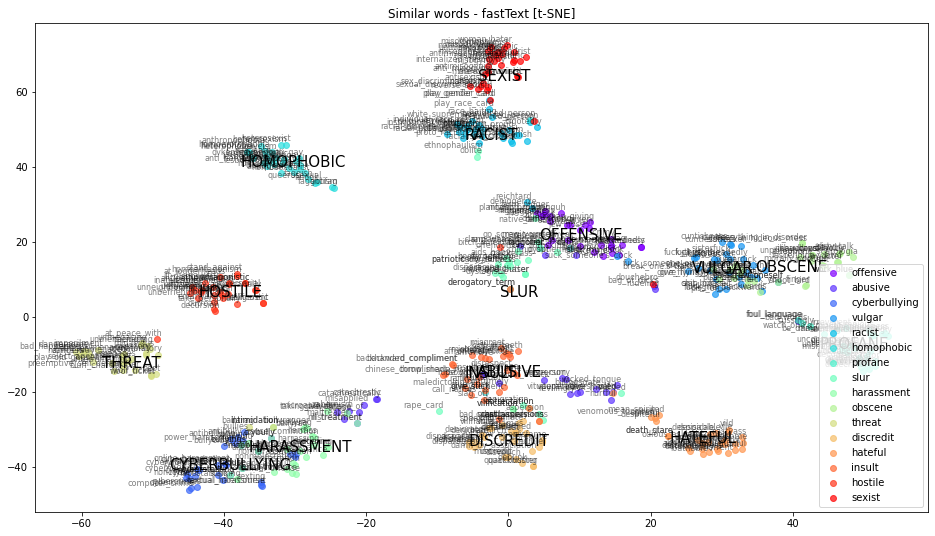

In [14]:
plotTSNE("Similar words - fastText [t-SNE]", word_clusters, embedding_clusters)

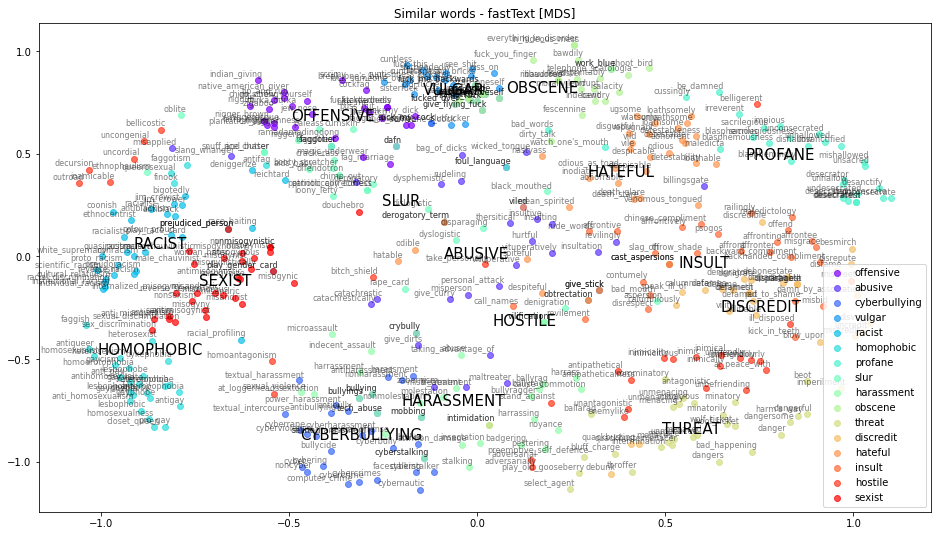

In [15]:
plotMDS("Similar words - fastText [MDS]", word_clusters, embedding_clusters)

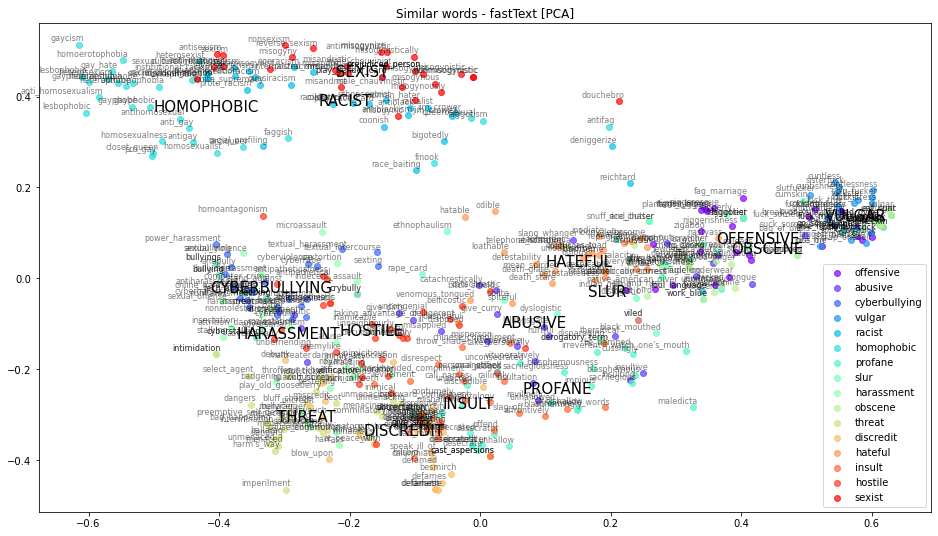

In [16]:
plotPCA("Similar words - fastText [PCA]", word_clusters, embedding_clusters)

### Main conclusions:

- We can observe that having the graph model ConceptNet as the core of the embeddings is beneficial. The vocabulary is rich, so when we search for similar words which need to be avoided, we find lots of them, and that was not necessarily the case with other pre-trained embeddings.


- The vocabulary richness is also observed when we look at the 30 most similar words to a term. There are some really expressive, really offensive words. However, it should also be noted that for some categories, the 30 most similar words are not a good match to the category in question.


- Clusters obtained by using t-SNE are well defined.